# Single-qubit states tests
This Jupyter Notebook is used to carry out the dynamical decoupling tests with the single-qubit states $|0\rangle$ and $|1\rangle$ and the three simple universal sequences XYXY, XZXZ and YZYZ (and free evolution IIII).

### Load the libraries

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

import numpy as np
import matplotlib.pyplot as plt

# For data fitting
from lmfit import Model

### Get the provider with your account id and set the backend (ibmq_lima)

In [2]:
provider = IBMQ.enable_account('your-ibmq-id-here')

In [3]:
backend = provider.get_backend('ibmq_lima')

### Get information about the duration of some of the instructions of the backend

In [6]:
# Get duration of instructions
dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",4)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",4)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",4)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",4)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",4)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",4)

### Define the function that generates the circuits

In [7]:
def get_transpiled_circuit(num_blocks, backend, 
                           X_duration, Y_duration, dt_in_s,
                           state=0, dynamicalDecoupling=True, sequence="XYXY"): 
    """
    state: 0, 1
    dynamicalDecoupling: True, False
    sequence: "XYXY", "XZXZ", "YZYZ"
    """
    
    # Backend's qubit used
    qubit = 4 
    
    # Duration of the 4-gate blocks of the sequences (the duration of a Z gate is 0)
    tau_block = {"XYXY":2*(X_duration+Y_duration),
                 "XZXZ":2*X_duration,
                 "YZYZ":2*Y_duration}
    
    # Initialize the quantum circuit object
    circuit = QuantumCircuit(5, 1)
    
    # Prepare the state
    if state==1:
        circuit.x(qubit)
    
    # Apply dynamical decoupling or wait
    if dynamicalDecoupling == True:   
        for i in range(num_blocks): # Put the sequence 4-gate blocks
            if sequence == "XYXY":
                circuit.x(qubit)
                circuit.y(qubit)
                circuit.x(qubit)
                circuit.y(qubit)
            elif sequence == "XZXZ":
                circuit.x(qubit)
                circuit.z(qubit)
                circuit.x(qubit)
                circuit.z(qubit)
            elif sequence == "YZYZ":
                circuit.y(qubit)
                circuit.z(qubit)
                circuit.y(qubit)
                circuit.z(qubit)
    elif dynamicalDecoupling == False:
        # Set the number of identity gates in a free evolution block 
        # so that it has the same duration as the block from the 
        # corresponding dynamical decoupling sequence
        num_ids = {"XYXY":6, "XZXZ":2, "YZYZ":4} 
        # Build the free evolution part.
        for i in range(num_blocks): # Put the identity gate blocks of the free evolution
            for j in range(num_ids[sequence]): # How a single block is built
                circuit.id(qubit)
         
    tau_wait = num_blocks*tau_block[sequence] # Duration of the dynamical decoupling sequence
    wait_duration = tau_wait*dt_in_s*1e6 # Convert the duration from system units (dt) to microseconds
    
    # Decode state back to |0>
    if state==1:
        circuit.x(qubit)
        
    # Measure
    circuit.measure(qubit,0)
    
    # Transpile the circuit
    transpiled_circuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return transpiled_circuit, wait_duration

### Parameters for creating the tests circuits

In [8]:
max_time   = 15 # In us.
num_steps  = 15
wait_times = np.linspace(0, max_time, num_steps)  # In microseconds.
#print(wait_times)

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case

shots = 2**13 # 8192
#print(shots)

states = [0, 1]
repetitions = 10

reshape_dims = (len(states), repetitions, 4, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))
#print("Number of jobs to be sent:", int(np.prod(reshape_dims)/100)+1)

### Build the circuits

In [9]:
all_wait_times = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |0>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |1>]
"""

for i, state in enumerate(states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []

    print("State:", state)
    print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     state=state, dynamicalDecoupling=True, sequence="XYXY")
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
        
    print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     state=state, dynamicalDecoupling=True, sequence="XZXZ")
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
        
    print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the XZXZ circuits.
        print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     state=state, dynamicalDecoupling=True, sequence="YZYZ")
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_transpiled_circuit(num_blocks, backend, 
                                                     X_duration, Y_duration, dt_in_s,
                                                     state=state, dynamicalDecoupling=False)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
        
    print("Done!")
print("Finished!")

State: 0
Generating the XYXY circuits...
	XYXY 0 1 15
	XYXY 0 2 15
	XYXY 0 3 15
	XYXY 0 4 15
	XYXY 0 5 15
	XYXY 0 6 15
	XYXY 0 7 15
	XYXY 0 8 15
	XYXY 0 9 15
	XYXY 0 10 15
	XYXY 0 11 15
	XYXY 0 12 15
	XYXY 0 13 15
	XYXY 0 14 15
	XYXY 0 15 15
Generating the XZXZ circuits...
	XZXZ 0 1 15
	XZXZ 0 2 15
	XZXZ 0 3 15
	XZXZ 0 4 15
	XZXZ 0 5 15
	XZXZ 0 6 15
	XZXZ 0 7 15
	XZXZ 0 8 15
	XZXZ 0 9 15
	XZXZ 0 10 15
	XZXZ 0 11 15
	XZXZ 0 12 15
	XZXZ 0 13 15
	XZXZ 0 14 15
	XZXZ 0 15 15
Generating the YZYZ circuits...
	YZYZ 0 1 15
	YZYZ 0 2 15
	YZYZ 0 3 15
	YZYZ 0 4 15
	YZYZ 0 5 15
	YZYZ 0 6 15
	YZYZ 0 7 15
	YZYZ 0 8 15
	YZYZ 0 9 15
	YZYZ 0 10 15
	YZYZ 0 11 15
	YZYZ 0 12 15
	YZYZ 0 13 15
	YZYZ 0 14 15
	YZYZ 0 15 15
Generating the IIII circuits...
	IIII 0 1 15
	IIII 0 2 15
	IIII 0 3 15
	IIII 0 4 15
	IIII 0 5 15
	IIII 0 6 15
	IIII 0 7 15
	IIII 0 8 15
	IIII 0 9 15
	IIII 0 10 15
	IIII 0 11 15
	IIII 0 12 15
	IIII 0 13 15
	IIII 0 14 15
	IIII 0 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repeti

C:\Users\usuario\AppData\Local\Temp\ipykernel_11592\3363455776.py:66: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
C:\Users\usuario\AppData\Local\Temp\ipykernel_11592\3363455776.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  circuits_array =

 1 4 15
	XYXY 1 5 15
	XYXY 1 6 15
	XYXY 1 7 15
	XYXY 1 8 15
	XYXY 1 9 15
	XYXY 1 10 15
	XYXY 1 11 15
	XYXY 1 12 15
	XYXY 1 13 15
	XYXY 1 14 15
	XYXY 1 15 15
Generating the XZXZ circuits...
	XZXZ 1 1 15
	XZXZ 1 2 15
	XZXZ 1 3 15
	XZXZ 1 4 15
	XZXZ 1 5 15
	XZXZ 1 6 15
	XZXZ 1 7 15
	XZXZ 1 8 15
	XZXZ 1 9 15
	XZXZ 1 10 15
	XZXZ 1 11 15
	XZXZ 1 12 15
	XZXZ 1 13 15
	XZXZ 1 14 15
	XZXZ 1 15 15
Generating the YZYZ circuits...
	YZYZ 1 1 15
	YZYZ 1 2 15
	YZYZ 1 3 15
	YZYZ 1 4 15
	YZYZ 1 5 15
	YZYZ 1 6 15
	YZYZ 1 7 15
	YZYZ 1 8 15
	YZYZ 1 9 15
	YZYZ 1 10 15
	YZYZ 1 11 15
	YZYZ 1 12 15
	YZYZ 1 13 15
	YZYZ 1 14 15
	YZYZ 1 15 15
Generating the IIII circuits...
	IIII 1 1 15
	IIII 1 2 15
	IIII 1 3 15
	IIII 1 4 15
	IIII 1 5 15
	IIII 1 6 15
	IIII 1 7 15
	IIII 1 8 15
	IIII 1 9 15
	IIII 1 10 15
	IIII 1 11 15
	IIII 1 12 15
	IIII 1 13 15
	IIII 1 14 15
	IIII 1 15 15
Building repetitions...
	Repetition 0
	Repetition 1
	Repetition 2
	Repetition 3
	Repetition 4
	Repetition 5
	Repetition 6
	Repetition 7
	Repetit

### Send the job to IBMQ (...)

In [ ]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='SingleQubitStates-8192shots-15us-15steps-10reps-q4', shots=shots)

Print the id of the job set for being able to retrieve it in the future.

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

For checking the progress of the jobs:

In [ ]:
statuses = job_set.statuses()
total = len(statuses)
done = 0

for status in statuses:
    if status.name == "DONE":
        done += 1
            
print(f"{done}/{total} jobs done.")
statuses

Get the results.

In [ ]:
results = job_set.results()

Get the counts from the results.

In [ ]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

### (...) or get the data shown in the paper

In [10]:
all_counts_array = np.load("all_counts_array-SingleQubitStates-8192shots-15us-15steps-10reps-q4.npy", allow_pickle=True)

### Reshape the counts to facilitate working with them

In [11]:
"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |0>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |1>]
            
reshape_dims = (number of states considered, repetitions, number of sequences, number of time steps) = (2, 10, 4, 15)
"""

reshaped_counts = all_counts_array.reshape(reshape_dims)
reshaped_counts

array([[[[{'0': 8113, '1': 79}, {'0': 7961, '1': 231},
          {'0': 7817, '1': 375}, ..., {'0': 6738, '1': 1454},
          {'0': 6649, '1': 1543}, {'0': 6613, '1': 1579}],
         [{'0': 8103, '1': 89}, {'0': 7940, '1': 252},
          {'0': 7721, '1': 471}, ..., {'0': 5977, '1': 2215},
          {'0': 5819, '1': 2373}, {'0': 5743, '1': 2449}],
         [{'0': 8117, '1': 75}, {'0': 7937, '1': 255},
          {'0': 7671, '1': 521}, ..., {'0': 5662, '1': 2530},
          {'0': 5434, '1': 2758}, {'0': 5333, '1': 2859}],
         [{'0': 8115, '1': 77}, {'0': 8113, '1': 79},
          {'0': 8117, '1': 75}, ..., {'0': 8107, '1': 85},
          {'0': 8114, '1': 78}, {'0': 8118, '1': 74}]],

        [[{'0': 8113, '1': 79}, {'0': 7987, '1': 205},
          {'0': 7846, '1': 346}, ..., {'0': 6745, '1': 1447},
          {'0': 6653, '1': 1539}, {'0': 6595, '1': 1597}],
         [{'0': 8102, '1': 90}, {'0': 7916, '1': 276},
          {'0': 7737, '1': 455}, ..., {'0': 5911, '1': 2281},
         

### Extract the data

Get the raw counts

In [12]:
counts0_0_XYXY = np.array([[reshaped_counts[0][i][0][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_XZXZ = np.array([[reshaped_counts[0][i][1][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_YZYZ = np.array([[reshaped_counts[0][i][2][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_IIII = np.array([[reshaped_counts[0][i][3][j]["0"] for j in range(num_steps)] for i in range(repetitions)])

counts0_1_XYXY = np.array([[reshaped_counts[1][i][0][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_XZXZ = np.array([[reshaped_counts[1][i][1][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_YZYZ = np.array([[reshaped_counts[1][i][2][j]["0"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_IIII = np.array([[reshaped_counts[1][i][3][j]["0"] for j in range(num_steps)] for i in range(repetitions)])

raw_counts00 = [[counts0_0_XYXY, counts0_0_XZXZ, counts0_0_YZYZ, counts0_0_IIII],
                [counts0_1_XYXY, counts0_1_XZXZ, counts0_1_YZYZ, counts0_1_IIII]]

Get the average of the repetitions

In [13]:
avg_counts0_0_XYXY = np.round(np.average(counts0_0_XYXY, axis=0)).astype(int)
avg_counts0_0_XZXZ = np.round(np.average(counts0_0_XZXZ, axis=0)).astype(int)
avg_counts0_0_YZYZ = np.round(np.average(counts0_0_YZYZ, axis=0)).astype(int)
avg_counts0_0_IIII = np.round(np.average(counts0_0_IIII, axis=0)).astype(int)

avg_counts0_1_XYXY = np.round(np.average(counts0_1_XYXY, axis=0)).astype(int)
avg_counts0_1_XZXZ = np.round(np.average(counts0_1_XZXZ, axis=0)).astype(int)
avg_counts0_1_YZYZ = np.round(np.average(counts0_1_YZYZ, axis=0)).astype(int)
avg_counts0_1_IIII = np.round(np.average(counts0_1_IIII, axis=0)).astype(int)

avg_counts0 = [[avg_counts0_0_XYXY, avg_counts0_0_XZXZ, avg_counts0_0_YZYZ, avg_counts0_0_IIII],
               [avg_counts0_1_XYXY, avg_counts0_1_XZXZ, avg_counts0_1_YZYZ, avg_counts0_1_IIII]]

Get the maximum count values of the repetitions

In [14]:
max_counts0_0_XYXY = np.max(counts0_0_XYXY, axis=0)
max_counts0_0_XZXZ = np.max(counts0_0_XZXZ, axis=0)
max_counts0_0_YZYZ = np.max(counts0_0_YZYZ, axis=0)
max_counts0_0_IIII = np.max(counts0_0_IIII, axis=0)

max_counts0_1_XYXY = np.max(counts0_1_XYXY, axis=0)
max_counts0_1_XZXZ = np.max(counts0_1_XZXZ, axis=0)
max_counts0_1_YZYZ = np.max(counts0_1_YZYZ, axis=0)
max_counts0_1_IIII = np.max(counts0_1_IIII, axis=0)

max_counts0 = [[max_counts0_0_XYXY, max_counts0_0_XZXZ, max_counts0_0_YZYZ, max_counts0_0_IIII],
               [max_counts0_1_XYXY, max_counts0_1_XZXZ, max_counts0_1_YZYZ, max_counts0_1_IIII]]

Get the minimum count values of the repetitions

In [15]:
min_counts0_0_XYXY = np.max(counts0_0_XYXY, axis=0)
min_counts0_0_XZXZ = np.max(counts0_0_XZXZ, axis=0)
min_counts0_0_YZYZ = np.max(counts0_0_YZYZ, axis=0)
min_counts0_0_IIII = np.max(counts0_0_IIII, axis=0)

min_counts0_1_XYXY = np.min(counts0_1_XYXY, axis=0)
min_counts0_1_XZXZ = np.min(counts0_1_XZXZ, axis=0)
min_counts0_1_YZYZ = np.min(counts0_1_YZYZ, axis=0)
min_counts0_1_IIII = np.min(counts0_1_IIII, axis=0)

min_counts0 = [[min_counts0_0_XYXY, min_counts0_0_XZXZ, min_counts0_0_YZYZ, min_counts0_0_IIII],
               [min_counts0_1_XYXY, min_counts0_1_XZXZ, min_counts0_1_YZYZ, min_counts0_1_IIII]]

### Plot the results

0 0
Name     Value   Stderr
C  -0.01406 0.001676
T     71.82    1.156

0 1
Name     Value   Stderr
C  -0.005784 0.003225
T     36.86   0.6792

0 2
Name     Value   Stderr
C  0.001286 0.002828
T     29.99   0.4233

0 3
Name     Value   Stderr
C  -0.008628 0.0001317
T  1.374e+04     2836

1 0
Name     Value   Stderr
C   -0.0177 0.001763
T      70.7    1.181

1 1
Name     Value   Stderr
C  -0.01287 0.003265
T     39.94   0.7888

1 2
Name     Value   Stderr
C  -0.01035 0.002766
T      35.8   0.5559

1 3
Name     Value   Stderr
C  -0.006958 0.002006
T      18.7   0.1445



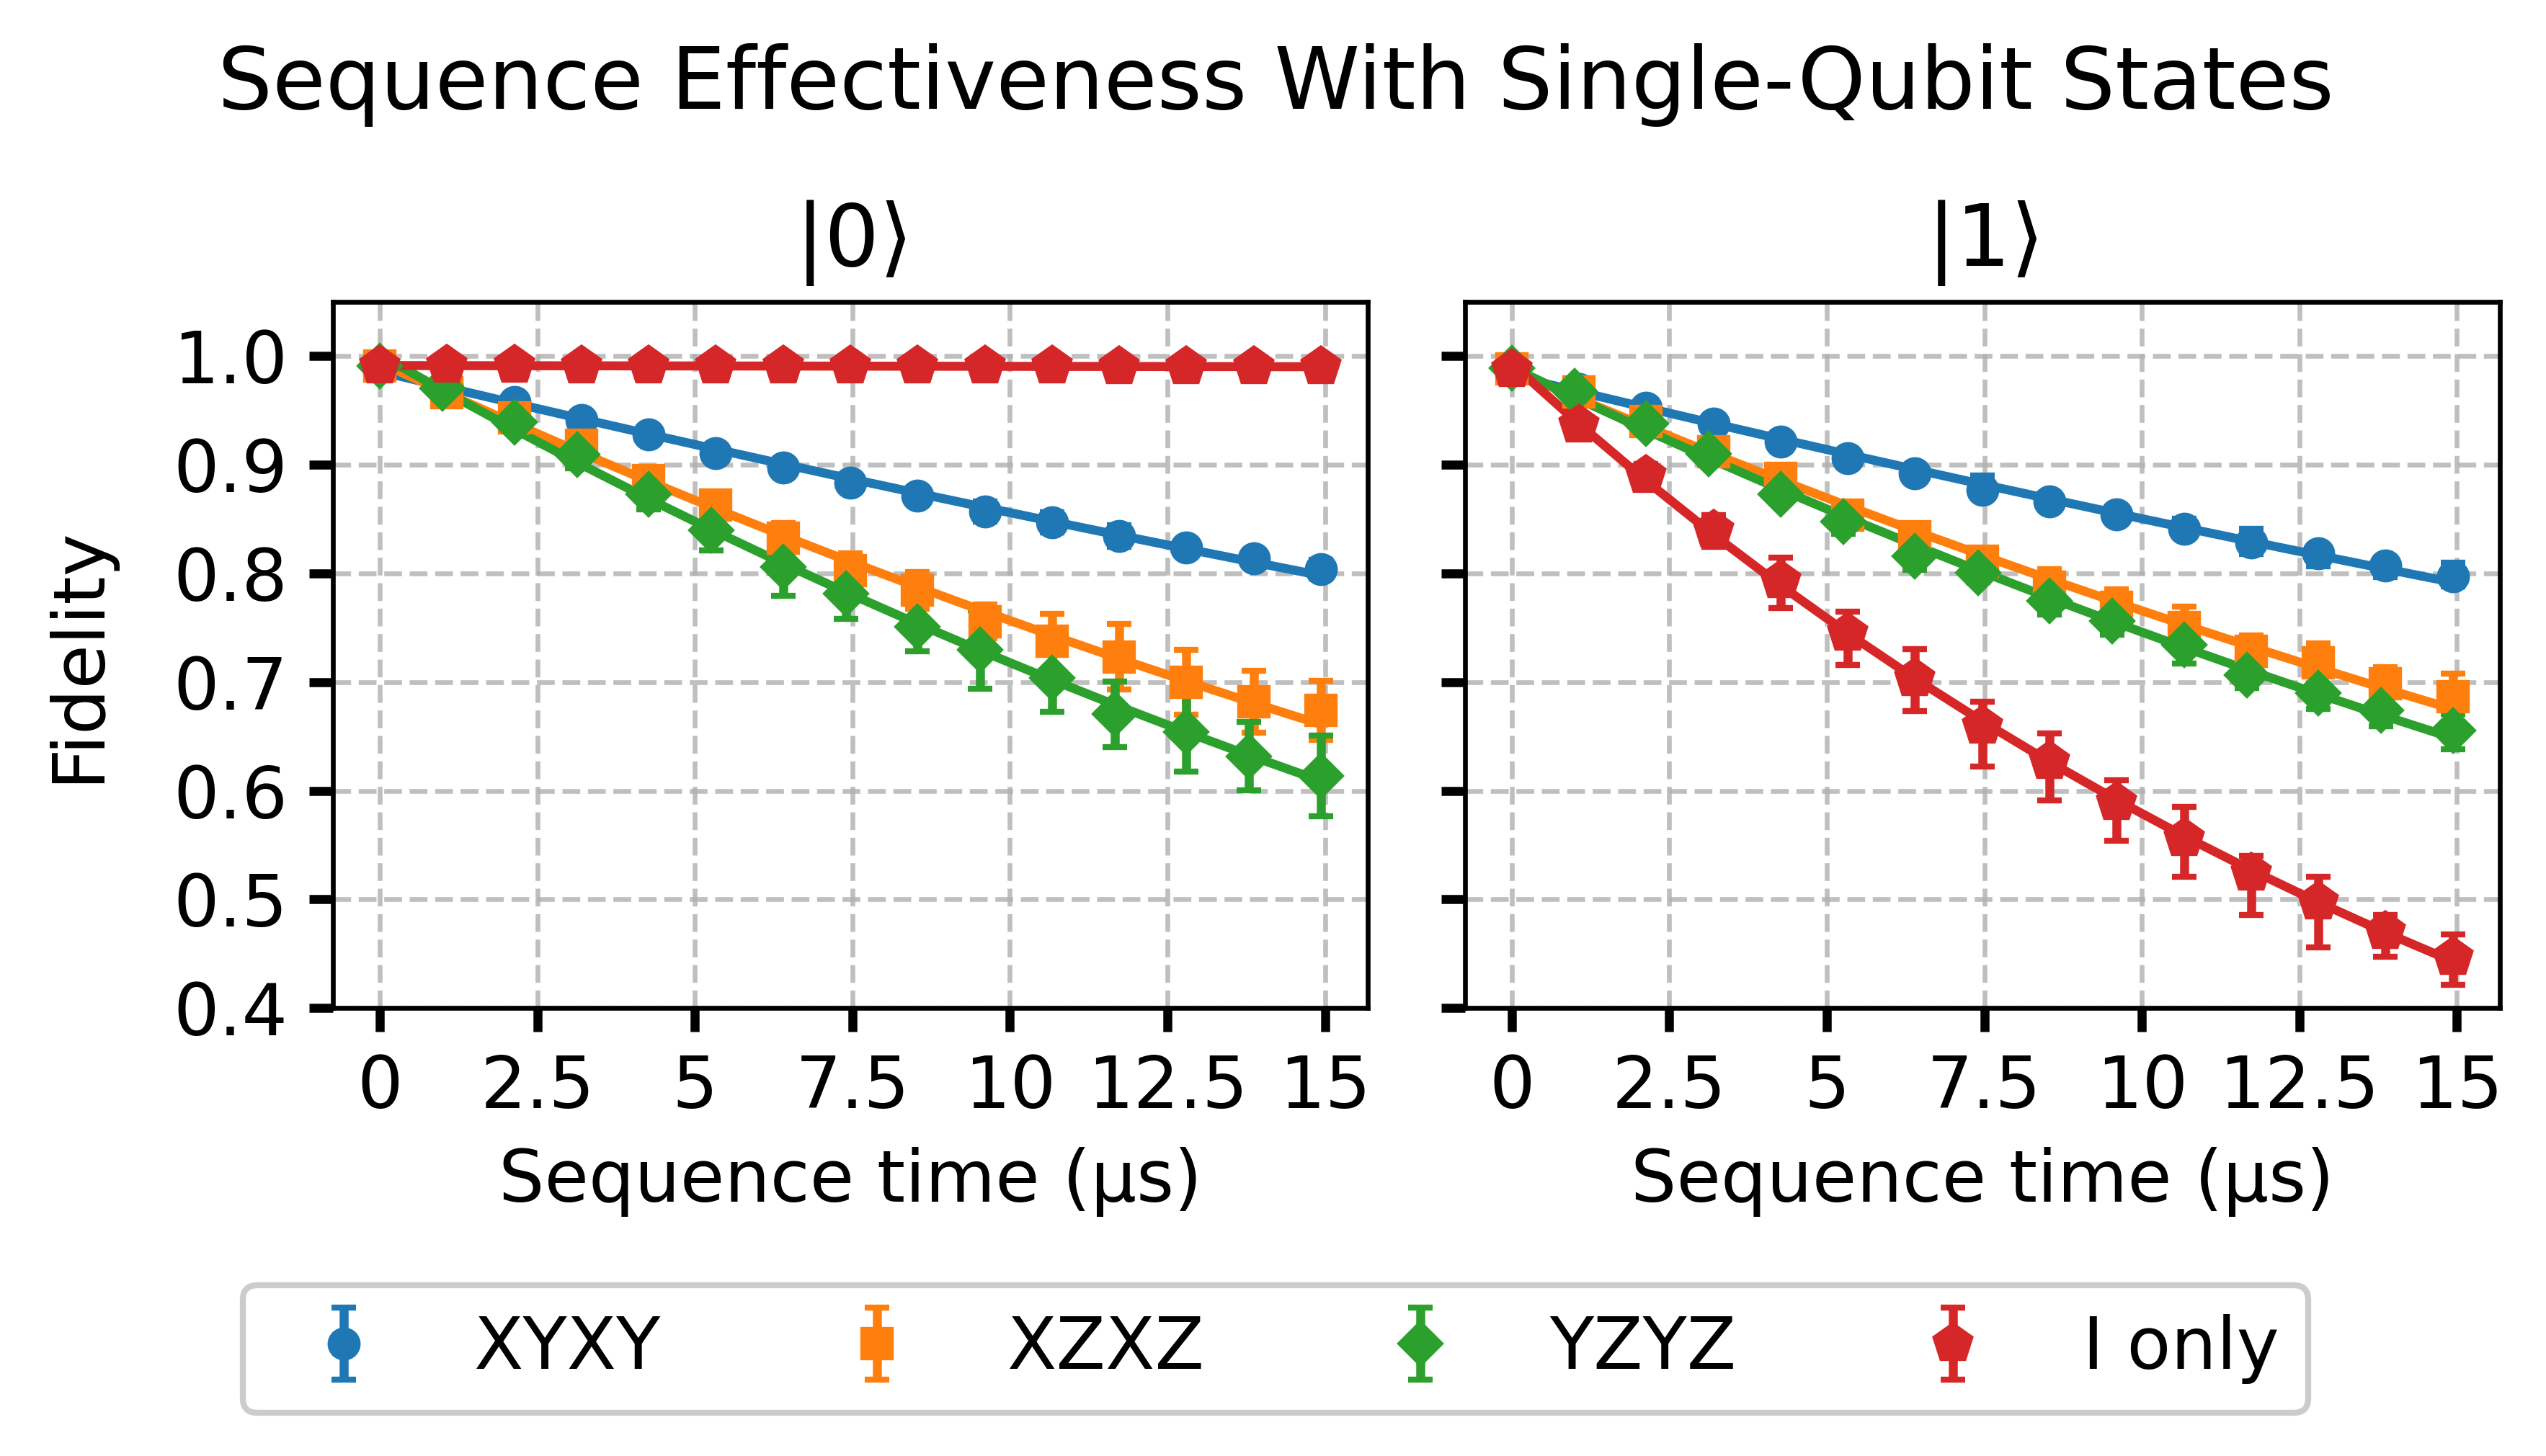

In [16]:
# Define the exponential decay for the fits
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

labels = ["$|0\\rangle$", "$|1\\rangle$"] # Title labels

# Create the figure and axes
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(6,3), constrained_layout=False, dpi=600)

fig.suptitle("Sequence Effectiveness With Single-Qubit States", fontsize="x-large", y=0.955)
axs[0].set_ylabel("Fidelity", labelpad=10, fontsize="large")

msize = 4.5 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1.5 # Line width
elw = 1.5 # Error bar line width
a = 1 # Alpha (transparency)
cs = 2 # Error bar cap size

# Marker options
marker_types = ["o", "s", "D", "p"]
marker_sizes = [msize, msize, msize, 6]

# Plot the results
for i in range(2): # For each state
        
    axs[i].set_title(labels[i], fontsize="x-large")
    axs[i].set_ylim((0.4,1.05))
    axs[i].set_xticks([0, 2.5, 5, 7.5, 10, 12.5, 15])
    axs[i].set_xticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15], fontsize="large")
    axs[i].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    axs[i].tick_params(width=1.5, length=4)
    
    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # Get the fidelities
    fidelity_XYXY = avg_counts0[i][0]/shots
    fidelity_XZXZ = avg_counts0[i][1]/shots
    fidelity_YZYZ = avg_counts0[i][2]/shots
    fidelity_IIII = avg_counts0[i][3]/shots
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts0[i][0]/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts0[i][0]/shots)
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts0[i][1]/shots)
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts0[i][1]/shots)
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts0[i][2]/shots)
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts0[i][2]/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts0[i][3]/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts0[i][3]/shots)
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[0], markeredgewidth=medgewidth, markersize=marker_sizes[0], 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[1], markeredgewidth=medgewidth, markersize=marker_sizes[1], 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[2], markeredgewidth=medgewidth, markersize=marker_sizes[2], 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=marker_types[3], markeredgewidth=medgewidth, markersize=marker_sizes[3], 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts0[i][k]/shots
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=100, min=0)
        exp_model.set_param_hint('C', value=0.5)
        fit_result = exp_model.fit(state_data, x=state_times)
        
        # Print the resulting fit parameters with their standard error
        print(i, k)
        fit_result.params.pretty_print(columns=["value", "stderr"])
        print()
        
        # Plot the curve of the best fit
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
     
    axs[i].grid(linestyle="--", alpha=0.8, zorder=0.1)

axs[0].set_yticklabels([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize="large")    
axs[0].set_xlabel("Sequence time (μs)", fontsize="large")
axs[1].set_xlabel("Sequence time (μs)", fontsize="large")

# Create the legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.025), fontsize="large", framealpha=1)

# Show
plt.tight_layout()
plt.show()
#plt.savefig(r"fidelitySingleQubit4.pdf")  